In [2]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.preprocessing
import matplotlib.pyplot as plt
import Utils
from Utils import evaluate_model, load_data, validate, train

#plt.rcParams['figure.figsize'] = [6.4, 4.8] #The default
plt.rcParams['figure.figsize'] = [20, 10]

path_train = "Data/Train.parquet"
path_val = "Data/Validation.parquet"

Note that trees do not need any data scaling

Baseline (the warnings are misleading and can be ignored):

In [24]:
features=["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]
baseline = DummyClassifier()
print("Training: ")
train(path_train,baseline,features)
print("Validation: ")
validate(baseline,path_val,features);

Training: 


/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Accuracy: 0.8905468036686415
Confusion: 
[[1. 0.]
 [1. 0.]]
MCC: 0.0
Validation: 
Accuracy: 0.8906060229873748
Confusion: 
[[1. 0.]
 [1. 0.]]
MCC: 0.0


/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.8906060229873748,
 array([[1., 0.],
        [1., 0.]]))

First we try training with raw hour information, no gender

In [6]:
def preprocess_1(data,features):
    """
    Note that this modifies data inplace
    """
    features = features + ["hour"]
    data["hour"] = data["starttime"].dt.hour
    return data,features

In [7]:
features=["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]

In [8]:
pre=preprocess_1
clf = DecisionTreeClassifier(max_depth=6)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf,path_val,features,preprocess=pre);

Training: 
Accuracy: 0.899347698861101
Confusion: 
[[0.98498342 0.01501658]
 [0.79741238 0.20258762]]
MCC: 0.3162768269893971
Validation: 
Accuracy: 0.8994086394588567
Confusion: 
[[0.98500111 0.01499889]
 [0.79742288 0.20257712]]
MCC: 0.316333970359959


Decision tree without any class/sample weighting and depth 6 reaches accuracy of 90% (98% on subscribers, 20% on customers)

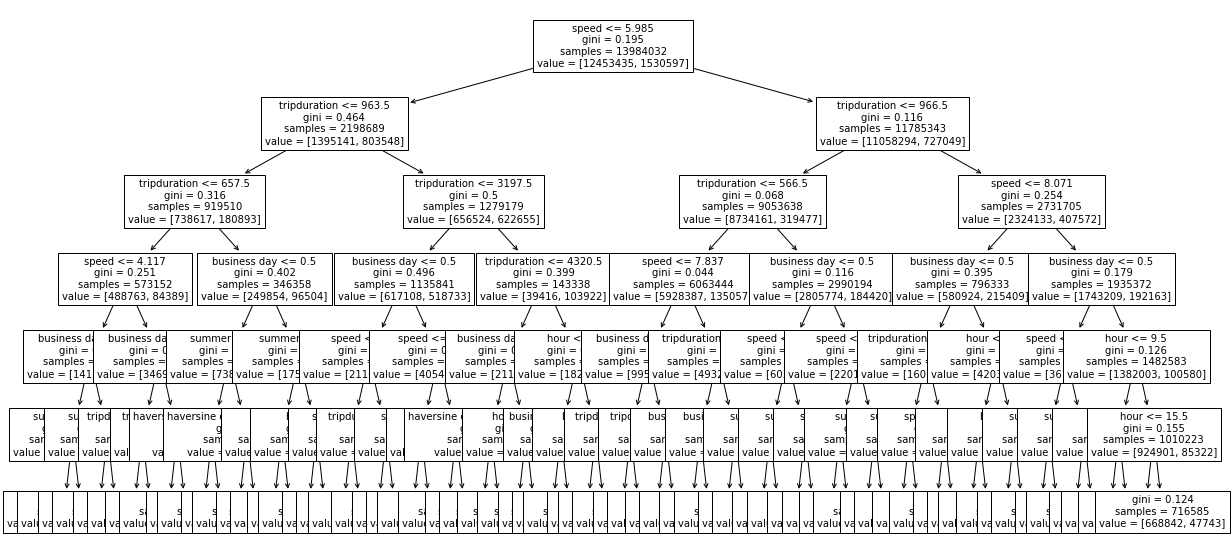

In [9]:
#plt.rcParams['figure.figsize'] = [6.4, 4.8]
plot_tree(clf,fontsize=10,feature_names=feature_names)
plt.show()

Seems to mainly use speed, tripduration and business day

Since we are not overfitting at all, lets try increasing depth first

In [10]:
clf = DecisionTreeClassifier(max_depth=12)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf,path_val,features,preprocess=pre);

Training: 
Accuracy: 0.9039440127139298
Confusion: 
[[0.97900916 0.02099084]
 [0.70681048 0.29318952]]
MCC: 0.38706441552302295
Validation: 
Accuracy: 0.9035167559781075
Confusion: 
[[0.97869066 0.02130934]
 [0.70849436 0.29150564]]
MCC: 0.38382790809615325


In [11]:
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf,path_val,features,preprocess=pre);

Training: 
Accuracy: 0.928912133496262
Confusion: 
[[0.98210984 0.01789016]
 [0.50392167 0.49607833]]
MCC: 0.5842437470598194
Validation: 
Accuracy: 0.8965259212941854
Confusion: 
[[0.96312265 0.03687735]
 [0.64565607 0.35434393]]
MCC: 0.38432254195614735


At this depth we are starting to outperform the logistic regression, even without using station ids, but also we see that we start overfitting.

Just out of interest, lets see how we perform if we use gender as a feature

In [13]:
features_gender = features + ["gender"]
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train,clf,features_gender,preprocess=preprocess_1)
print("Validation: ")
validate(clf,path_val,features_gender,preprocess=preprocess_1);

Training: 
Accuracy: 0.9622322088507806
Confusion: 
[[0.9937944  0.0062056 ]
 [0.29456807 0.70543193]]
MCC: 0.7924297958617819
Validation: 
Accuracy: 0.9386093730960416
Confusion: 
[[0.98018284 0.01981716]
 [0.39985148 0.60014852]]
MCC: 0.6555033256027879


This is actually quite similar to the performance of logistic regression with gender as a feature.

Ideas:
1. use gender => cheating
2. use station ids
2. tree pruning
3. balance class weights
4. random forest
5. use station ids
6. Compute some more interesting features such as other seasons, better TOD information, trip directions?

First we try adding station ids "raw", with no encoding

In [17]:
features_station=["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre=preprocess_1

In [18]:
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train,clf,features_station,preprocess=pre)
print("Validation: ")
validate(clf,path_val,features_station,preprocess=pre);

Training: 
Accuracy: 0.9470291543955277
Confusion: 
[[0.98715953 0.01284047]
 [0.37948461 0.62051539]]
MCC: 0.7019191263581055
Validation: 
Accuracy: 0.9003171047189278
Confusion: 
[[0.95912273 0.04087727]
 [0.57843542 0.42156458]]
MCC: 0.4318419286884088


(0.9003171047189278,
 array([[0.95912273, 0.04087727],
        [0.57843542, 0.42156458]]))

This notably increases accuracy on customers, but hurts subscribers a tiny bit.

What about frequency encoded stations? -> Does not seem to help, so we stick with preprocess_1

In [19]:
def preprocess_2(data,features):
    data,features = preprocess_1(data,features) # add hours
    data = Utils.frequency_encode_stations(data,data)
    features = features + ["star customer freq","stop customer freq", "start subscriber freq", "stop subscriber freq"]
    return data,features

In [20]:
clf = DecisionTreeClassifier(max_depth=24)
features=["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=preprocess_2)
print("Validation:")
validate(clf,path_val,features,preprocess=preprocess_2);

Training: 
Accuracy: 0.9497084245802642
Confusion: 
[[0.98861615 0.01138385]
 [0.36685751 0.63314249]]
MCC: 0.7178363759619953
Validation:
Accuracy: 0.897656354136692
Confusion: 
[[0.95800954 0.04199046]
 [0.59369525 0.40630475]]
MCC: 0.4148235875351225


Lets see what happens if we balance classes (and include station)

In [21]:
clf = DecisionTreeClassifier(max_depth = 24,class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_train,clf,features_station,preprocess=preprocess_1)
print("Validation:")
validate(clf,path_val,features_station,preprocess=preprocess_1);

Training: 
Accuracy: 0.8738295936393738
Confusion: 
[[0.86808033 0.13191967]
 [0.07939255 0.92060745]]
MCC: 0.5961298884341207
Validation:
Accuracy: 0.828571804510633
Confusion: 
[[0.84271851 0.15728149]
 [0.28660032 0.71339968]]
MCC: 0.42033023610070736


This really hurts the overall accuracy (it falls below the baseline of 89%), but significantly improves accuracy on customers. MCC is minimally improved.
We also see that we are overfitting to some extent. We could try increasing depth and then pruning.

Next, let us start training really deep trees and see what happens. Maybe we can even add some pruning.

In [25]:
clf = DecisionTreeClassifier(class_weight="balanced", max_depth=None)
print("Training: ")
clf,feature_names = train(path_train,clf,features_station,preprocess=preprocess_1)
print("Validation:")
validate(clf,path_val,features_station,preprocess=preprocess_1);

Training: 
Accuracy: 0.9993057796206416
Confusion: 
[[9.99220536e-01 7.79463658e-04]
 [6.53339841e-07 9.99999347e-01]]
MCC: 0.9964550728421022
Validation:
Accuracy: 0.8852278857644981
Confusion: 
[[0.93503201 0.06496799]
 [0.52024098 0.47975902]]
MCC: 0.4132226255558471


In [26]:
clf.get_depth()

76

TODO: Grid search over depths and pruning parameters. After that lets do a random forest.

In [ ]:
ccp_alpha=0.1
print("Training: ")
clf,feature_names = train(path_train,features_station,preprocess=preprocess_1,class_weight="balanced", max_depth=None, ccp_alpha =ccp_alpha)
print("Validation:")
validate(clf,path_val,features_station,preprocess=preprocess_1);

Training: 
